In [1]:
!pip install --upgrade wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 1.6 MB/s eta 0:00:00
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.16
    Uninstalling wandb-0.12.16:
      Successfully uninstalled wandb-0.12.16


In [2]:
import time
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

import pytorch_lightning as pl 

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets
from torchvision import transforms

In [3]:
import wandb

try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("wandb_api")
    wandb.login(key=api_key)
    anony = None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307), std=(0.3081))
])
print(device)

cuda:0


In [5]:
train_dataset = datasets.MNIST(root='data',
                              train=True,
                              download=True,
                              transform=data_transform )

test_dataset = datasets.MNIST(root='data',
                              train=False,
                              download=True,
                              transform=data_transform)

print(train_dataset[0][0].shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw

torch.Size([1, 28, 28])


In [6]:
train_loader = DataLoader(train_dataset,
                         batch_size=16,
                         shuffle=True,
                         num_workers=2)

test_loader = DataLoader(test_dataset,
                         batch_size=16,
                         shuffle=False,
                         num_workers=2)

In [7]:
class Conv_Block(nn.Module):
    def __init__(self, in_channel, out_channel):
        super(Conv_Block,self).__init__()
        self.conv = nn.Conv2d(in_channel, out_channel, 3, 1)
        self.bn = nn.BatchNorm2d(out_channel)
        self.act = nn.ReLU()
        self.pool = nn.MaxPool2d(2)
        
    def forward(self, x):
        x = self.conv(x)
        x = self.act(self.bn(x))
        x = self.pool(x)
        
        return x 

class MINST_Net(nn.Module):
    def __init__(self, in_channel=1, out_channel=[6, 16], num_class=10):
        super(MINST_Net,self).__init__()
        layer = []
        in_channel = in_channel
        for i in out_channel:
            layer.append(Conv_Block(in_channel, i))
            in_channel = i
        
        self.layer = nn.Sequential(*layer)
        self.fc1 = nn.Linear(in_channel , 120)
        self.fc2 = nn.Linear(120 ,84)
        self.fc3 = nn.Linear(84, num_class)
        
    def forward(self, x):
        x = self.layer(x)
        x = nn.AvgPool2d(5)(x)
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

class Light_model(pl.LightningModule):
    def __init__(self, backbone, loss_fn, optim_arg, scheduler_arg):
        super().__init__()
        
        self.backbone = backbone
        self.loss_fn = loss_fn
        self.optim = optim_arg
        self.scheduler = scheduler_arg
    
    def forward(self, x):
        return self.backbone(x)
    
    def shared_step(self, bacth, prefix='', on_step=False):
        x,y = bacth
        pred = self(x)
        
        loss = self.loss_fn(pred, y)
        
        if self.training is not None:
            self.log(f'{prefix}_loss', loss, on_step=on_step, on_epoch=True, prog_bar=True, logger=True)

        return loss
    
    def training_step(self, bacth, bacth_idx):
        return self.shared_step(bacth, 'train', True)
    
    def validation_step(self, bacth, bacth_idx):
        return self.shared_step(bacth, 'val', False)
    
    def configure_optimizers(self):
        parameters = [x for x in self.backbone.parameters() if x.requires_grad]
        optim = torch.optim.Adam(parameters, **self.optim)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, **self.scheduler)
        
        return [optim], [{'scheduler': scheduler, 'interval': 'epoch'}]
# net = MINST_Net()
# test_img = torch.rand((2,1,28,28))
# pred = net(test_img)
# print(pred.shape)

In [8]:
max_epoch = 10

net = MINST_Net()
net.to(device)
criterion = nn.CrossEntropyLoss()
# pl_net = Light_model(net, criterion, {'lr': 1e-4}, {'T_max':max_epoch, 'eta_min':1e-6})
optim = torch.optim.Adam(net.parameters(), lr=1e-4)
lr_sc = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=max_epoch, eta_min=1e-6)
print(net)

MINST_Net(
  (layer): Sequential(
    (0): Conv_Block(
      (conv): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): Conv_Block(
      (conv): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
      (bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act): ReLU()
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
  )
  (fc1): Linear(in_features=16, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [9]:
run = wandb.init(project='MINST', 
                job_type='Train',
                anonymous='must')


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [10]:
def train_loop(model, dataloader, optim, scheduler=None):
    model.train()
    tk = tqdm(dataloader, total=len(dataloader))
    
    for batch in tk:
        image = batch[0].to(device)
        target = batch[1].to(device)

        pred = model(image)
        losses = criterion(pred, target)
        optim.zero_grad()
        losses.backward()
        optim.step()
        
        if scheduler is not None:
            scheduler.step()
            wandb.log({"Lr_step_end": lr_sc.get_last_lr()[0]})
            
        mean_loss = torch.mean(losses)
        tk.set_postfix(loss=mean_loss)
        
    return mean_loss

def val_loop(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    
    tk = tqdm(dataloader, total=len(dataloader))
    with torch.no_grad():
        for batch in tk:
            image = batch[0].to(device)
            target = batch[1].to(device)

            pred = model(image)
            losses = criterion(pred, target)

            mean_loss = torch.mean(losses)
            
            _, y_hat = torch.max(pred.data, dim = 1)
            total += image.size(0)
            correct += (y_hat == target).sum().item()
            
            tk.set_postfix(loss=mean_loss)
        
        accury = correct / total
        
        return mean_loss,accury

In [11]:
print(f'Using {device} ...')
# logger = pl.loggers.WandbLogger(project='MINST',
#                                save_dir='~/')

# trainer = pl.Trainer(logger=logger,
#                     max_epochs=10)

# trainer.fit(pl_net, train_dataloaders=train_loader, val_dataloaders=test_loader)
best_score = -np.inf

for epoch in range(max_epoch):
    print(f'Start Epoch_{epoch+1} Training ....')
    
    start_time = time.time()
    
    train_loss = train_loop(net, train_loader, optim)
    
    lr_sc.step()
    
    elapsed = time.time() - start_time
    
    valid_loss, accury = val_loop(net, test_loader)
    
    wandb.log({"Train Loss": train_loss})
    wandb.log({"Valid Loss": valid_loss})
    wandb.log({"Accuracy": accury})
    wandb.log({"Lr_epoch_end": lr_sc.get_last_lr()[0]})
    
    if accury > best_score:
        print(f">>>>>>>> Model Improved From {best_score} ----> {accury}")
        torch.save(net.state_dict(), f'model_ck.bin')
        best_score = accury
        run.summary["Best Score"] = best_score
        
    print(f'Epoch {epoch+1} - avg_train_loss: {train_loss:.5f}  avg_val_loss: {valid_loss:.5f}  time: {elapsed:.0f}s')
    

Using cuda:0 ...
Start Epoch_1 Training ....


100%|██████████| 625/625 [00:05<00:00, 118.79it/s, loss=tensor(0.9166, device='cuda:0')]


>>>>>>>> Model Improved From -inf ----> 0.6419
Epoch 1 - avg_train_loss: 1.14148  avg_val_loss: 0.91660  time: 46s
Start Epoch_2 Training ....


100%|██████████| 625/625 [00:05<00:00, 120.33it/s, loss=tensor(0.5836, device='cuda:0')]


>>>>>>>> Model Improved From 0.6419 ----> 0.7294
Epoch 2 - avg_train_loss: 0.98949  avg_val_loss: 0.58356  time: 40s
Start Epoch_3 Training ....


100%|██████████| 625/625 [00:04<00:00, 130.14it/s, loss=tensor(0.4364, device='cuda:0')]


>>>>>>>> Model Improved From 0.7294 ----> 0.7734
Epoch 3 - avg_train_loss: 1.50321  avg_val_loss: 0.43636  time: 40s
Start Epoch_4 Training ....


100%|██████████| 625/625 [00:05<00:00, 109.01it/s, loss=tensor(0.4038, device='cuda:0')]


>>>>>>>> Model Improved From 0.7734 ----> 0.7991
Epoch 4 - avg_train_loss: 0.88991  avg_val_loss: 0.40384  time: 40s
Start Epoch_5 Training ....


100%|██████████| 625/625 [00:05<00:00, 110.58it/s, loss=tensor(0.3521, device='cuda:0')]


>>>>>>>> Model Improved From 0.7991 ----> 0.8164
Epoch 5 - avg_train_loss: 0.68901  avg_val_loss: 0.35211  time: 41s
Start Epoch_6 Training ....


100%|██████████| 625/625 [00:04<00:00, 127.82it/s, loss=tensor(0.3377, device='cuda:0')]


>>>>>>>> Model Improved From 0.8164 ----> 0.829
Epoch 6 - avg_train_loss: 0.66860  avg_val_loss: 0.33767  time: 41s
Start Epoch_7 Training ....


100%|██████████| 625/625 [00:05<00:00, 106.35it/s, loss=tensor(0.3086, device='cuda:0')]


>>>>>>>> Model Improved From 0.829 ----> 0.8437
Epoch 7 - avg_train_loss: 0.38495  avg_val_loss: 0.30856  time: 41s
Start Epoch_8 Training ....


100%|██████████| 625/625 [00:05<00:00, 112.13it/s, loss=tensor(0.2893, device='cuda:0')]


>>>>>>>> Model Improved From 0.8437 ----> 0.8498
Epoch 8 - avg_train_loss: 0.76566  avg_val_loss: 0.28934  time: 41s
Start Epoch_9 Training ....


100%|██████████| 625/625 [00:05<00:00, 116.49it/s, loss=tensor(0.2774, device='cuda:0')]


>>>>>>>> Model Improved From 0.8498 ----> 0.8531
Epoch 9 - avg_train_loss: 0.54607  avg_val_loss: 0.27741  time: 41s
Start Epoch_10 Training ....


100%|██████████| 625/625 [00:05<00:00, 105.76it/s, loss=tensor(0.2854, device='cuda:0')]


Epoch 10 - avg_train_loss: 0.54275  avg_val_loss: 0.28543  time: 42s


In [12]:
run.finish()

Accuracy,▁▄▅▆▇▇████
Lr_epoch_end,█▇▇▆▅▃▂▂▁▁
Train Loss,▆▅█▄▃▃▁▃▂▂
Valid Loss,█▄▃▂▂▂▁▁▁▁
Accuracy,0.8531
Best Score,0.8531
Lr_epoch_end,0.0
Train Loss,0.54275
Valid Loss,0.28543


In [13]:
def test_and_show(model_ckp):
    model = MINST_Net()
    model.to(device)
    model.load_state_dict(torch.load(model_ckp))
    model.eval()

    fig = plt.figure(figsize=(15,15))
    for i in range(16):
        image = test_dataset[i][0]
        label = test_dataset[i][1]
        plt.subplot(4,4, i+1)
        plt.imshow(image.squeeze(0), cmap='gray')

        with torch.no_grad():
            pred = model(image.to(device).unsqueeze(0))

        plt.title(f'True:{label}  Pred:{pred.detach().cpu().numpy().argmax(1)[0]}', fontsize=16)

    plt.show()

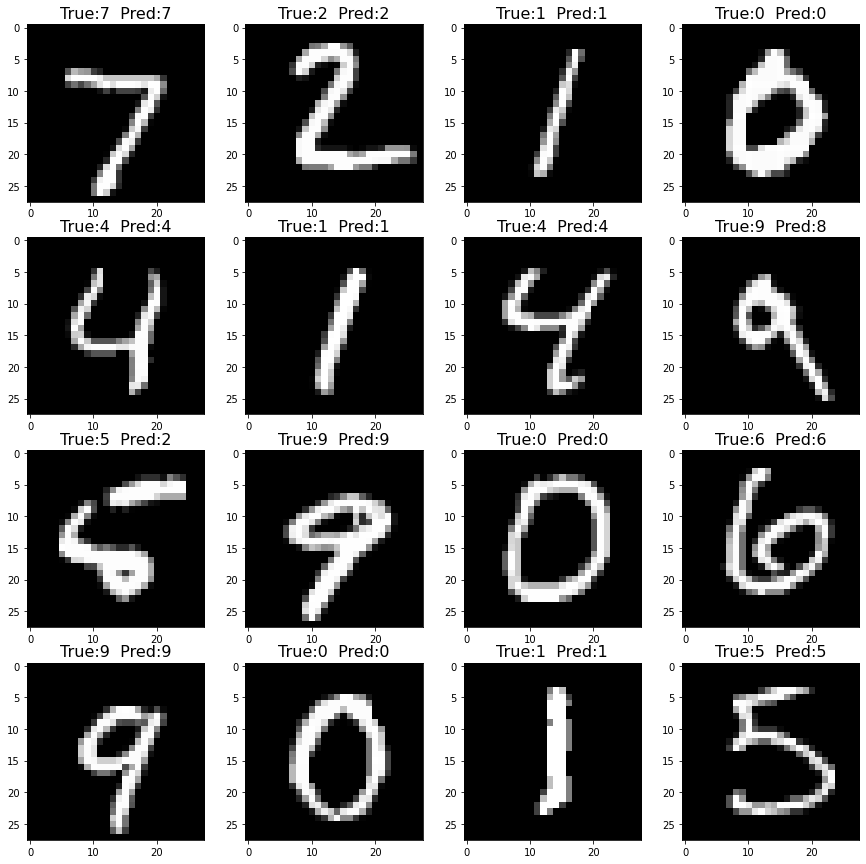

In [14]:
model_ckp = "/kaggle/working/model_ck.bin"
test_and_show(model_ckp)